In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [2]:
url = "data/cleaned.csv"

In [3]:
df = pd.read_csv(url, index_col=0)
df[df.select_dtypes(["object"]).columns] = df.select_dtypes(["object"]).apply(
    lambda x: x.astype("category")
)

In [4]:
original = pd.read_csv(url, index_col=0)
original[original.select_dtypes(["object"]).columns] = original.select_dtypes(["object"]).apply(
    lambda x: x.astype("category")
)

X = original.drop(columns='total_usage')
y = original['total_usage']

In [5]:
lgb_params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "rmse",
    #'max_depth': 8,
    "num_leaves": 20,
    "bagging_fraction": 0.2,
    "feature_fraction": 0.2,
    "learning_rate": 0.001,
    "verbose": 1,
    "lambda_l2": 2,
}

In [6]:
from sklearn.model_selection import cross_validate
import lightgbm as lgb
from lightgbm import LGBMRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

model = LGBMRegressor(
    boosting_type="gbdt",
    n_estimators = 40000,
    reg_lambda=2,
    num_leaves=20,
    learning_rate=0.001,
    subsample=0.2,
    colsample_bytree=0.2,
    n_jobs = 8,
)

In [8]:
model_cv = cross_validate(
    estimator = model,
    X = X_train,
    y=y_train,
    cv = 5,
    n_jobs=8,
    return_estimator=True,
)

In [9]:
model_cv['test_score']

array([0.71721663, 0.73577661, 0.7363056 , 0.74664648, 0.75250861])

In [60]:
#lgb.create_tree_digraph(model_cv['estimator'][1])
#plt.show()

In [12]:
feature_importance = [
    model_cv["estimator"][i].feature_importances_
    for i in range(0, len(model_cv["estimator"]))
]
feature_importance = pd.DataFrame(data=feature_importance, columns=X.columns)
feature_importance = feature_importance.reindex(
    feature_importance.mean().sort_values(ascending=False).index, axis=1
)

In [40]:
categorical_features_pallete = {
    x: 'g' for x in original.select_dtypes(include=["category"]).columns
}
corr = original.corr()["total_usage"][:-1]

corr_pallete = dict(zip(corr.index, ["r" if x > 0 else "b" for x in corr]))
corr_pallete.update(categorical_features_pallete)

In [57]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color="red", label="Positive correlated")
blue_patch = mpatches.Patch(color="blue", label="Negative correlated")
green_patch = mpatches.Patch(color="green", label="Categorical")
color_patches = [red_patch, blue_patch, green_patch]

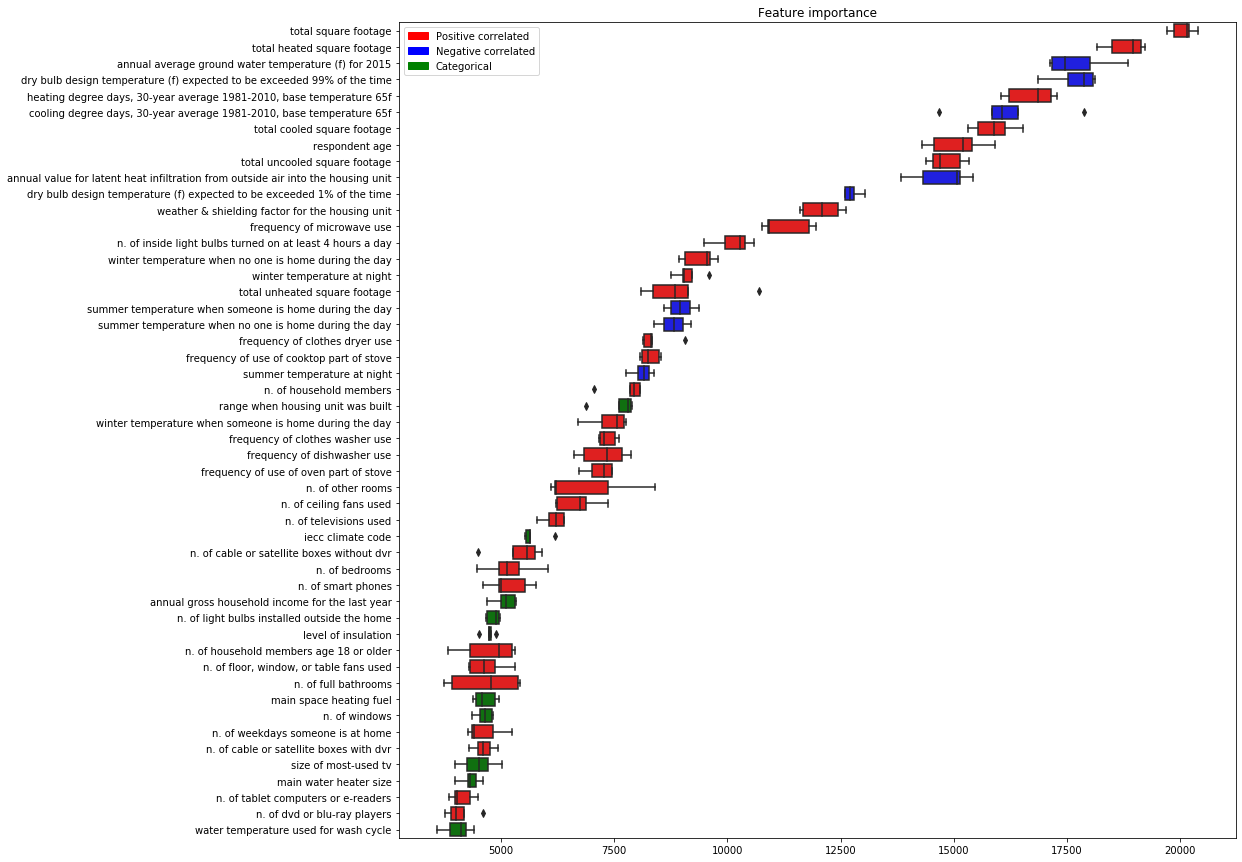

In [56]:
plt.figure(figsize=(15, 15))
sns.boxplot(data=feature_importance.iloc[:, 0:50], orient="h", palette=corr_pallete)
plt.title("Feature importance")
plt.legend(handles=color_patches)
plt.show()

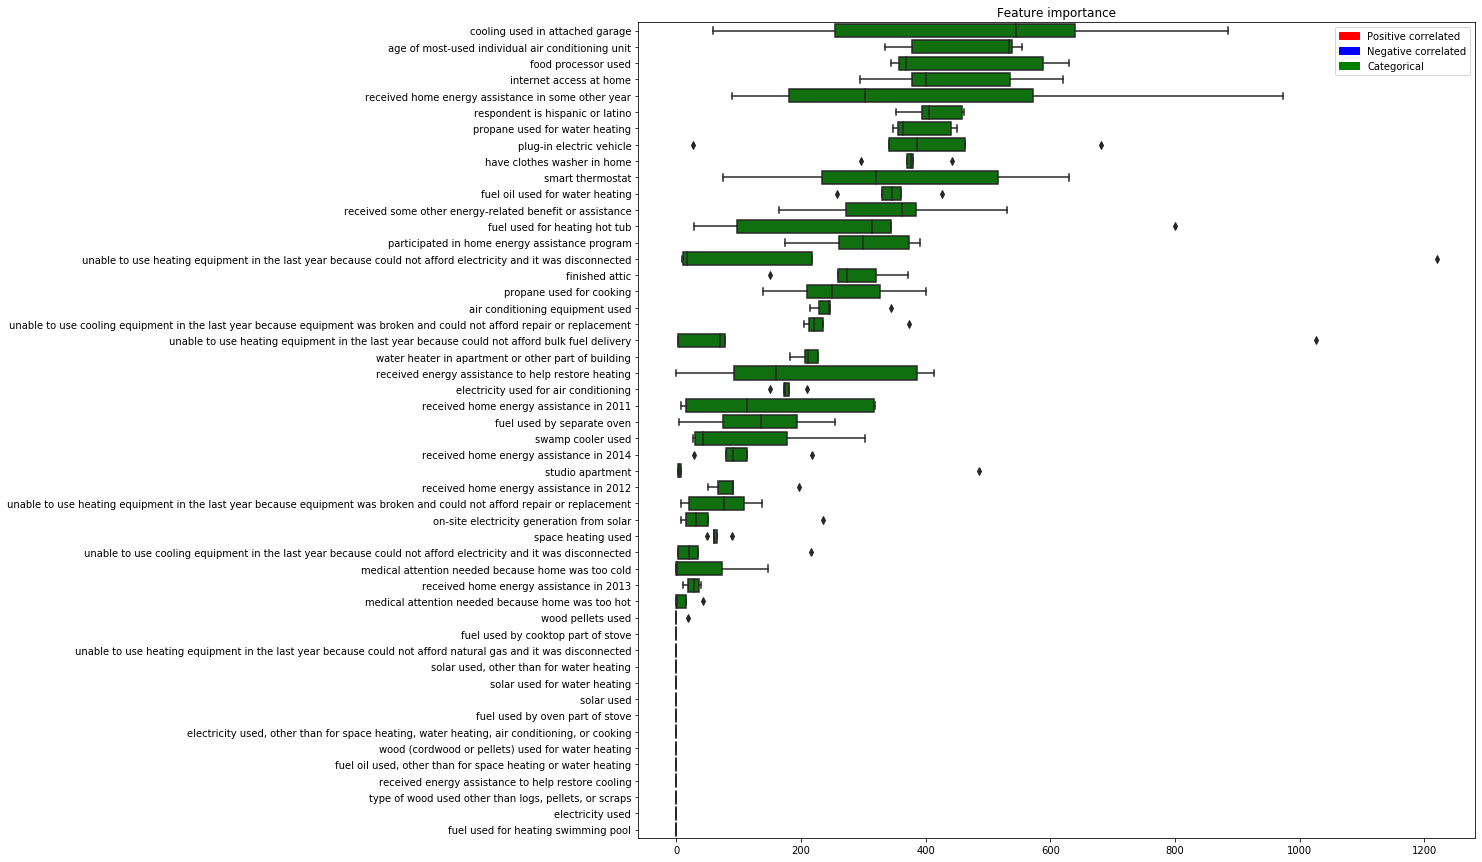

In [58]:
plt.figure(figsize=(15, 15))
sns.boxplot(data=feature_importance.iloc[:, -50:], orient="h", palette=corr_pallete)
plt.title("Feature importance")
plt.legend(handles=color_patches)
plt.show()

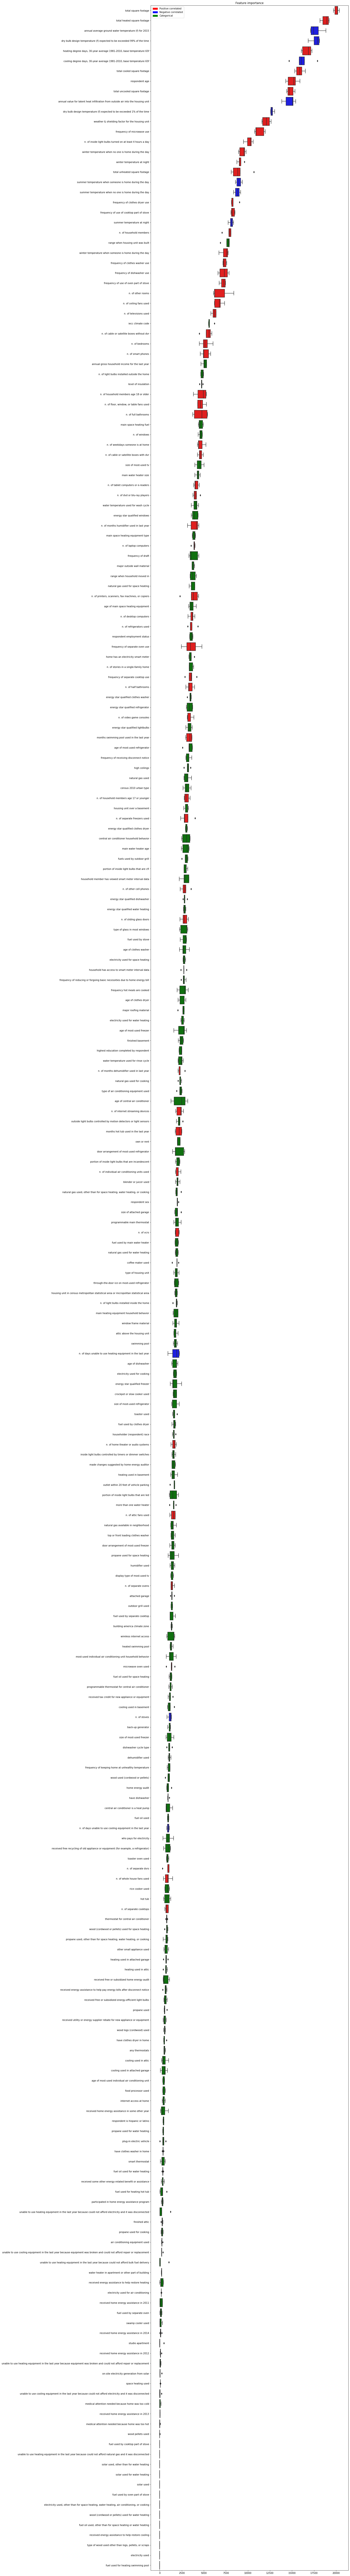

In [59]:
plt.figure(figsize=(15, 200))
sns.boxplot(data=feature_importance, orient="h", palette=corr_pallete)
plt.title("Feature importance")
plt.legend(handles=color_patches)
plt.show()